In [1]:
import sys 
sys.path.append(rf"/nfs/home/genovese/thesis-wildfire-genovese/src")
from importlib import reload
import utils
reload(utils)
from utils import *
data_folder = "/nfs/home/genovese/thesis-wildfire-genovese/data/"

# Ignition points xls

In [ ]:
ignition_points = pd.read_excel("data/raw/INCENDI_T_INCENDIO.xls")
ignition_points

In [ ]:
# convert coordinates format to lat/lon
# transformer = Transformer.from_crs("EPSG:32632", "EPSG:4326", always_xy=True)
# ignition_points['WGS84EST'], ignition_points['WGS84NORD'] = transformer.transform(ignition_points['WGS84EST'], ignition_points['WGS84NORD'])

# Convert DataFrame to GeoDataFrame
ignition_points = gpd.GeoDataFrame(ignition_points, 
                              geometry=gpd.points_from_xy(ignition_points['WGS84EST'], ignition_points['WGS84NORD'])
                              )

In [ ]:
file = ignition_points
filename = 'ignition_points'

save_clean_data(file, filename)

---

# Vectorial files

In [ ]:
# import all the files of fire spread
fire_surfaces = {} 
with zipfile.ZipFile(zip_file, 'r') as z:
    for file in z.namelist():
        try:
            fire_surfaces[file] = gpd.read_file(f"zip://{zip_file}!{file}")
        finally:
            continue

In [ ]:
fire_surfaces.keys()

In [ ]:
# check whether all these files have equal data
print([fire_surfaces[i].shape == fire_surfaces[j].shape for i,j in list(zip(list(fire_surfaces.keys())[:-1], list(fire_surfaces.keys())[1:]))])
print([string.split('.')[-1] for string in list(fire_surfaces.keys())])

There are two different files: *INC_SDO_PL_INCENDI* and *INC_SDO_PT_INCENDIO*

In [ ]:
file_type_1 = fire_surfaces['shp_scarico_geoportale/INC_SDO_PL_INCENDI.shp']
display(file_type_1)
file_type_2 = fire_surfaces['shp_scarico_geoportale/INC_SDO_PT_INCENDIO.shp']
display(file_type_2)

---

## Vectorial Ignition Points

In [ ]:
~file_type_2['geometry'].isin(ignition_points['geometry'])

In [ ]:
# remove all spaces to have uniform data
shp = file_type_2['id_incendi']
xls = ignition_points['ID_INCENDI']

print('Ignitions in the shp not in the xls: ', shp[~shp.isin(xls)], '\n')
print('Ignitions in the xls not in the shp: ', xls[~xls.isin(shp)])

In [ ]:
ignition_points[ignition_points['ID_INCENDI'].isin(xls[~xls.isin(shp)])]

In [ ]:
print(file_type_2.info())

In [ ]:
ignition_points.info()

There is some missing data in the xls, none in the shp

In [ ]:
print("xls' NA wildfires inside the shp's wildfires")
file_type_2[file_type_2['id_incendi'].isin(ignition_points[ignition_points['WGS84EST'].isna()]['ID_INCENDI'])]

In [ ]:
display(file_type_2.sort_values('id_incendi').iloc[0, :])
display(ignition_points.sort_values('ID_INCENDI').iloc[0, :])
print(file_type_2.sort_values('id_incendi').iloc[0, -1] == ignition_points.sort_values('ID_INCENDI').iloc[0, -1])

The two file geometries have different accuracies. I can merge the two dataframe to the same accuracy

In [ ]:
merged_ignitions = ignition_points.merge(file_type_2.rename({'id_incendi': 'ID_INCENDI'}, axis=1),
                      on='ID_INCENDI', 
                      how='left')
merged_ignitions.info()

In [ ]:
merged_ignitions[~merged_ignitions['cod_ince'].isin(merged_ignitions['COD_FASCIC'])]

Cod_ince and COD_FASCIC are the same thing
<br>I want to keep the more precise geometry which is geometry_y, and fill the previous NAs

In [ ]:
mask = merged_ignitions['geometry_y'].isna()
merged_ignitions['geometry_y'][mask] = gpd.points_from_xy(
    merged_ignitions['WGS84EST'][mask], merged_ignitions['WGS84NORD'][mask])

merged_ignitions = merged_ignitions.drop('geometry_x', axis=1
    ).replace(to_replace=merged_ignitions['cod_ince'], value = merged_ignitions['COD_FASCIC']
        ).drop('cod_ince', axis=1
               ).rename({'geometry_y': 'geometry'}, axis=1
                        )

mask = merged_ignitions['WGS84EST'].isna()
merged_ignitions['WGS84EST'][mask] = merged_ignitions['WGS84EST'][mask].fillna(merged_ignitions[mask]['geometry'].x)
mask = merged_ignitions['WGS84NORD'].isna()
merged_ignitions['WGS84NORD'][mask] = merged_ignitions['WGS84NORD'][mask].fillna(merged_ignitions[mask]['geometry'].y)

merged_ignitions.info()

2 wildfires left with no geographical data. I won't drop them since if I can identify the respective burnt area I can take the centroid as ignition point 

In [ ]:
file = merged_ignitions
filename = 'ignition_points'

save_clean_data(file, filename)

---

## Vectorial burnt areas

In [ ]:
burnt_areas = file_type_1
burnt_areas.info()
display(burnt_areas)

Everything looks fine here in terms of formats and values

In [ ]:
file = burnt_areas
filename = 'burnt_areas'

save_clean_data(file, filename)

---

# Ignition - Surface overlay

In [ ]:
ignition_points = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/data/clean_data/ignition_points/ignition_points.shp')
burnt_areas = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/data/clean_data/burnt_areas/burnt_areas.shp')

ignition_points.info()
print('\n')
burnt_areas.info()

In [ ]:
# some preliminary checks
print('The two coordinate systems are equal: ', ignition_points.crs == burnt_areas.crs)
print('There are duplicated rows: ')
print('Ignitions: ', ignition_points.duplicated().any())
print('Fires: ', burnt_areas.duplicated().any())

There are evidently many ignition points with no fire spreaded. Check whether each fire has an ignition point

In [ ]:
mask = burnt_areas['id_incendi'].isin(ignition_points['ID_INCENDI'])
burnt_areas[~mask]

Check whether all the ignitions lie in the respective burnt area

In [ ]:
merged_fires = burnt_areas.merge(ignition_points.rename({'ID_INCENDI': 'id_incendi'}, axis=1), on="id_incendi", how="inner")
merged_fires[~merged_fires.geometry_x.contains(merged_fires.geometry_y)]

There seem to be 500 fires where ignition is not inside burnt area. Let's check the distance between point and area

In [ ]:
def get_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    outliers = series[(series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)]
    return outliers

In [ ]:
oop_ignitions = merged_fires[~merged_fires.geometry_x.contains(merged_fires.geometry_y)
                             ].rename({'geometry_x': 'polygons', 'geometry_y': 'points'}, axis=1)
oop_distances = oop_ignitions['points'].distance(oop_ignitions['polygons'])

histbox(oop_distances, xlabel='Distance between ignition and fire (m)', title='Distribution of distance between ignition and fire')

In [ ]:
main_oop_distances = oop_distances[~oop_distances.isin(get_outliers(oop_distances))]
histbox(main_oop_distances)
oop_distances.describe()

In [ ]:
display(merged_fires.describe())
display(merged_fires.describe(include='geometry'))
display(merged_fires.describe(include= 'object'))

There seem to be some duplicated ignition points. Let's verify that they are actually two different fires

## Overlapping ignitions

In [ ]:
overlapping_ignitions = merged_fires[merged_fires['geometry_y'].duplicated(keep=False)]
for id, group in overlapping_ignitions.groupby('geometry_y'):
    print(id)
    display(group)

In [ ]:
def print_map(gdfs, ax, total_bounds=None, msize=2): # Plot both layers together
    for i, gdf in enumerate(gdfs):
        if gdf.geom_type.iloc[0] == 'Point':
            gdf.plot(ax=ax, color= plt.cm.rainbow(i), markersize=msize, aspect=1) # aspect=1 means ratio between y-axis and x-axis unit of measure = 1
        if gdf.geom_type.iloc[0] == 'Polygon':
            gdf.plot(ax=ax, color= plt.cm.rainbow(i+10), edgecolor="black", aspect=1, alpha=.5)
        
    if total_bounds == None:
        ax.set_xlim(min([g.total_bounds[0] for g in gdfs]), max([g.total_bounds[2] for g in gdfs]))
        ax.set_ylim(min([g.total_bounds[1] for g in gdfs]), max([g.total_bounds[3] for g in gdfs]))
    else:
        ax.set_xlim(total_bounds[0], total_bounds[2])
        ax.set_ylim(total_bounds[1], total_bounds[3])

In [ ]:
for id, group in overlapping_ignitions.groupby('geometry_y'):
    print(id)
    print(group['geometry_x'].distance(group['geometry_y']), '\n')

    fig, ax = plt.subplots(1,2, figsize=(10,6))
    print_map([group.rename({'geometry_x': 'geometry'}, axis=1).iloc[[0],:], group.rename({'geometry_y': 'geometry'}, axis=1).iloc[[0],:]], ax=ax[0], msize=100)
    print_map([group.rename({'geometry_x': 'geometry'}, axis=1).iloc[[1],:], group.rename({'geometry_y': 'geometry'}, axis=1).iloc[[1],:]], ax=ax[1], msize=100)
    plt.show()

---

In [ ]:
extract_zipfile(data_folder+"EFFIS_IT_EL_FR_PT_2021_2024.zip", data_folder+"raw/effis_2/")

In [ ]:
gdf = gpd.read_file(data_folder+"raw/effis_2/997560879a274791b45c8e0aea2ac2d1.json")
gdf.info()

In [ ]:
piemonte = gdf[gdf['admlvl2'] == 'Piemonte']
piemonte.drop(columns=['iso2', 'iso3', 'country', 'admlvl1', 'admlvl2', 'admlvl3', 'area_code', 'eu_area', 'noneu'], inplace = True)
piemonte.info()

Same thing as before

---

<Figure size 600x600 with 0 Axes>

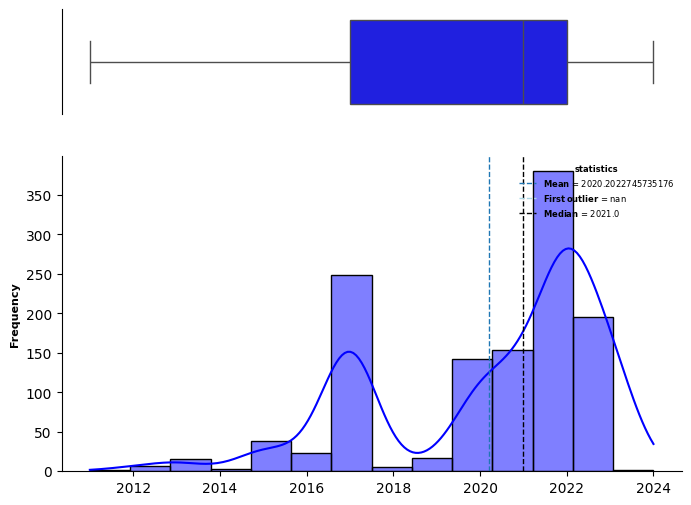

In [13]:
gdf = gpd.read_file(data_folder + "nicola/piedmont_2012_2024_fa.geojson")
burnt = separate_date(gdf, 'initialdate')
histbox(burnt['YYYY'])
